### Cluster state knitting
Let's build some cluster states out of elementary gates.

In [2]:
%matplotlib inline
import numpy as np
import qutip as qt
import matplotlib
import matplotlib.pyplot as plt
from functools import reduce
import networkx as nx


def show_graph(V, E):
    G = nx.Graph()
    G.graph['dpi'] = 40
    G.add_nodes_from(V)
    G.add_edges_from(E)
    return nx.draw(G, nx.spring_layout(G), labels={i: str(i) for i in V})

In [3]:
from qutip.qip.gates import swap

X = qt.sigmax()
Y = qt.sigmay()
Z = qt.sigmaz()
CZ = qt.qip.gates.controlled_gate(Z)
def cz(i=0, j=1, N=4):
    return qt.qip.gates.controlled_gate(
        Z, N=N, control=i, target=j
    )

CNOT = qt.qip.gates.cnot()
Id = X**2
SZ = CZ * swap()
def sz(i=0, j=1, N=4):
    return cz(i=i, j=j, N=N) * swap(
        N=N, targets=[i, j])

ket_0 = qt.Qobj(np.array([1, 0]).reshape((2, 1)))
ket_plus = qt.hadamard_transform() * ket_0

def graph_state_unitary(n, E):
    # n = |V|
    # E = [(i, j), ...]
    return reduce(
        lambda a, b: a*b,
        (qt.qip.gates.controlled_gate(
            Z, N=n,
            control=i, target=j
        )
        for i, j in E)
    )

### 1D cluster state generation

False
True


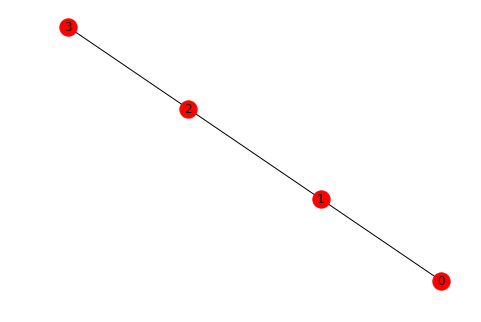

In [4]:
# desired graph edges
E = [(0, 1), (1, 2), (2, 3)]
show_graph(range(4), E)

# initial state
Psi = qt.tensor(4*[ket_plus])

# cluster-state generation procedure
procedure_1D = sz(0, 1) * sz(0, 2) * sz(0, 3)

print(procedure_1D == graph_state_unitary(4, E))
print(procedure_1D * Psi == graph_state_unitary(4, E) * Psi)

^^ 
the procedure yields the desired state, but does not apply the same unitary operation

### 2D cluster state generation

False
True


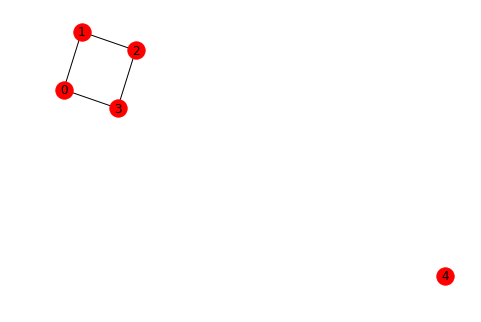

In [5]:
# use 5 qubits this time
# we will use qubit index 4 as flying qubit
N = 5

# desired graph edges (square)
E = [(0, 1), (1, 2), (2, 3), (3, 0)]
show_graph(range(N), E)

# initial state
Psi = qt.tensor(N*[ket_plus])

# cluster-state generation procedure
procedure_2D = swap(targets=[4, 3], N=N) * cz(i=4, j=0, N=N) * cz(i=4, j=2, N=N) * \
    swap(targets=[4, 1], N=N) * cz(i=4, j=0, N=N) * cz(i=4, j=2, N=N)

print(procedure_2D == graph_state_unitary(5, E))
print(procedure_2D * Psi == graph_state_unitary(5, E) * Psi)

### 3D cluster state generation

False
False


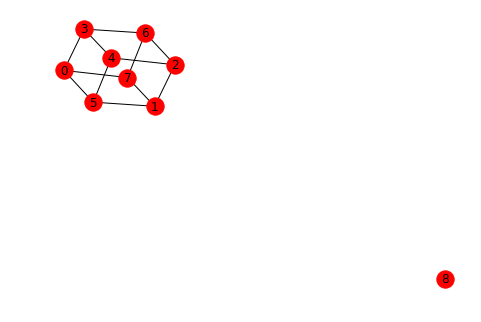

In [6]:
N = 9

f = 8

# desired graph edges (cube)
E = [(0, 3),
 (0, 5),
 (0, 7),
 (1, 2),
 (1, 5),
 (1, 7),
 (2, 4),
 (2, 6),
 (3, 4),
 (3, 6),
 (4, 5),
 (6, 7)]

show_graph(range(N), E)

# initial state
Psi = qt.tensor(N*[ket_plus])

# cluster-state generation procedure
# 1, 2, 6, 7
lower_square = swap(targets=[f, 6], N=N) * cz(i=f, j=7, N=N) * cz(i=f, j=2, N=N) * \
    swap(targets=[f, 1], N=N) * cz(i=f, j=7, N=N) * cz(i=f, j=2, N=N)
# 3 - (6, 4, 0)
upper_corner_1 = swap(targets=[f, 3], N=N) * cz(i=f, j=6, N=N) * cz(i=f, j=4, N=N) * \
    cz(i=f, j=0, N=N)

# 5 - (1, 4, 0)
upper_corner_2 = swap(targets=[f, 5], N=N) * cz(i=f, j=1, N=N) * cz(i=f, j=4, N=N) * \
    cz(i=f, j=0, N=N)

# I'm not sure how to connect these last missing edges
## 2 - 4
# bar_1 = 
## 0 - 7
# bar_2 = 

procedure_3D = upper_corner_2 * upper_corner_1 * lower_square

print(procedure_3D == graph_state_unitary(9, E))
print(procedure_3D * Psi == graph_state_unitary(9, E) * Psi)

### Error propagation in the 2D cluster state procedure

True
False
False


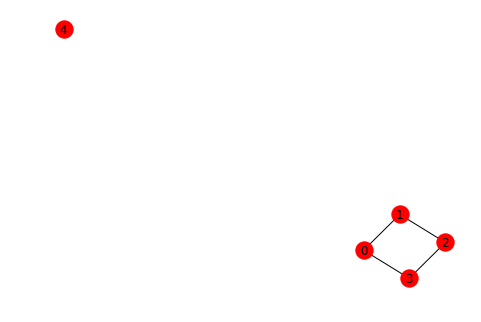

In [31]:
N = 5
# flying qubit index
f = 4

# desired graph edges (square)
E = [(0, 1), (1, 2), (2, 3), (3, 0)]
show_graph(range(N), E)

# initial state
Psi = qt.tensor(N*[ket_plus])


e = qt.tensor([X if i == f else Id for i in range(N)])

# cluster-state generation procedure
procedure_2D_error = swap(targets=[f, 3], N=N) * cz(i=f, j=0, N=N) * cz(i=f, j=2, N=N) * \
    swap(targets=[f, 1], N=N) * \
    e * \
    cz(i=f, j=0, N=N) * cz(i=f, j=2, N=N)

X3 = qt.tensor([X if i == 3 else Id for i in range(N)])

print(X3 * procedure_2D_error * Psi == graph_state_unitary(N, E) * Psi)
print(X3 * procedure_2D_error == procedure_2D)
print(X3 * procedure_2D_error == graph_state_unitary(N, E))

- Error $\sigma_x$ on $f$ just before its first SWAP(f, 3) just amounts to a X on 3.
- This is unsurprising -- more interesting case is when 3 then continues the pattern

### Knitting a larger 2D cluster state with X error:

True
False
True


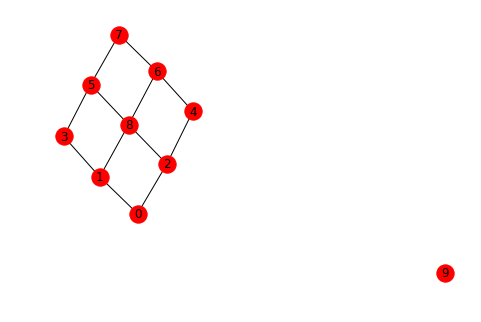

In [77]:
N = 10
# flying qubit index
f = 9

E = [(0, 1), (0, 2), (1, 3), (4, 2),
     (3, 5), (5, 7), (7, 6),
     (6, 4),
     (2, 8), (8, 1), (8, 5), (8, 6)]

show_graph(range(N), E)

# initial state
Psi = qt.tensor(N*[ket_plus])


e = qt.tensor([X if i == f else Id for i in range(N)])

knit = lambda i, j, k: swap(targets=[f, j], N=N) * cz(i=f, j=i, N=N) * cz(i=f, j=k, N=N)
procedure = knit(6, 7, 5) * knit(4, 6, 8) * knit(3, 5, 8) * knit(2, 8, 1) *\
    knit(2, 0, 1) *\
    swap(targets=[3, f], N=N) * cz(f, 1, N) *\
    swap(targets=[4, f], N=N) * cz(f, 2, N)

print(procedure * Psi == graph_state_unitary(N, E) * Psi)

X8 = qt.tensor([X if i == 8 else Id for i in range(N)])
procedure_with_error = knit(6, 7, 5) * knit(4, 6, 8) * knit(3, 5, 8) *\
    X8 *\
    knit(2, 8, 1) *\
    knit(2, 0, 1) *\
    swap(targets=[3, f], N=N) * cz(f, 1, N) *\
    swap(targets=[4, f], N=N) * cz(f, 2, N)

print(procedure_with_error * Psi == graph_state_unitary(N, E) * Psi)
X0 = qt.tensor([X if i == 0 else Id for i in range(N)])
print(X0 * procedure_with_error * Psi == graph_state_unitary(N, E) * Psi)

#### The $\sigma_x^{(8)}$ error is propagated to a local $\sigma_x^{(0)}$ error at the end of the circuit!